In [1]:
import pandas as pd
import LAZY_PIPELINE as lpipe

In [2]:
df = lpipe.load_data('heart_failure_clinical_records_dataset')
print(df.shape)
df.head()

(300, 13)


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood-pressure,platelets,serum_cretinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,False
1,75,0,582,0,20,1,265000,1.9,130,1,0,4,True
2,55,0,7861,0,38,0,263358.03,1.1,136,1,0,6,True
3,65,0,146,0,20,0,162000,1.3,129,1,1,7,True
4,50,1,111,0,20,0,210000,1.9,137,1,0,7,True


In [3]:
y_name = 'DEATH_EVENT'
y = df[y_name]
X = lpipe.binarize_X(df.drop(y_name, axis=1))
print(y.shape)
print(X.shape)
X.head()

(300,)
(300, 685)


,age: 40,age: 41,age: 42,age: 43,age: 44,age: 45,age: 46,age: 47,age: 48,age: 49,...,time: 86,time: 87,time: 88,time: 90,time: 91,time: 94,time: 95,time: 96,time: 97,time: time
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [4]:
X = X.sample(frac=1, random_state=42)  # Shuffle X
y = y[X.index]  # Order y to follow the order of rows from X

In [5]:
X_bin = [set(X.columns[x]) for idx, x in X.iterrows()]
X_bin[:1]

[{'age: 70',
  'anaemia: 0',
  'creatinine_phosphokinase: 97',
  'diabetes: 0',
  'ejection_fraction: 60',
  'high_blood-pressure: 1',
  'platelets: 220000',
  'serum_cretinine: 0.9',
  'serum_sodium: 138',
  'sex: 1',
  'smoking: 0',
  'time: 186'}]

In [67]:
n_train= int(len(X)*0.9)
n_test = len(X) - n_train
n_test, n_train

(511, 4599)

In [7]:
y_test = y[n_train:]

In [8]:
%%time
gen = lpipe.predict_array(X_bin, y, n_train, use_tqdm=True)
y_preds, t_preds = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|██████████████████████████████████████████████████████| 300/300 [00:00<00:00, 276.95it/s]

CPU times: total: 953 ms
Wall time: 993 ms


In [9]:
%%time
gen = list(lpipe.predict_array(X_bin, y, n_train, use_tqdm=True, update_train=False))
y_preds_fixedtrain, t_preds_fixedtrain = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|█████████████████████████████████████████████████████| 300/300 [00:00<00:00, 5470.38it/s]

CPU times: total: 46.9 ms
Wall time: 52.4 ms


In [11]:
from sklearn.metrics import accuracy_score, f1_score

score_vals = {}
for score_f in [accuracy_score, f1_score]:
    score_name = score_f.__name__
#    print(score_name)
    preds = y_preds
    score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]
    
    score_name = score_f.__name__ + '_fixedtrain'
    preds = y_preds_fixedtrain
    score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]

print ("Accuracy : ", accuracy_score(y_test,y_preds)*100)
print("F1-score: ", f1_score(y_test, y_preds) * 100)

Accuracy :  68.14814814814815
F1-score:  8.510638297872342


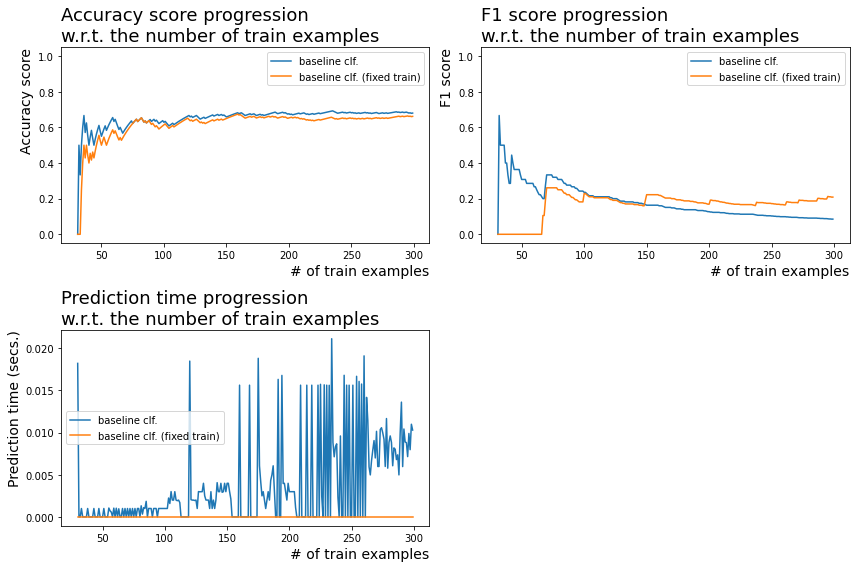

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = (1,1,1,1)  # Replace default "transparent" background of the figure with the "white" one


fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# First two plots are for prediction quality comparison
for ax, t in zip(axs[0],['accuracy_score', 'f1_score']):
    ax.set_ylim(0-0.05, 1+0.05)
    ax.plot(range(n_train+1, len(X)), score_vals[t], label='baseline clf.')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_fixedtrain'], label='baseline clf. (fixed train)')
    
# The third plot is for prediction speed comparison
axs[1,0].plot(range(n_train, len(X)), t_preds, label='baseline clf.')
axs[1,0].plot(range(n_train, len(X)), t_preds_fixedtrain, label='baseline clf. (fixed train)')

# Add labels and titles to the plots
for (ax, t_verb, dim) in zip(axs.flatten(), ['Accuracy score', 'F1 score','Prediction time'], ['','','(secs.)']):
    ax.set_title('\n'.join([f"{t_verb} progression", "w.r.t. the number of train examples"]), loc='left', size=18)
    ax.set_xlabel('# of train examples', loc='right', size=14)
    ax.set_ylabel(f"{t_verb} {dim}".strip(), loc='top', size=14)
    ax.legend()
    
# Drop the predefined fourth plot since we do not use it
axs[1,1].set_axis_off()    

# Some postprocessing of plots
plt.tight_layout()
plt.subplots_adjust()

plt.savefig('Classifier_comparison.png')
plt.show()

In [1]:
import pandas as pd
import LAZY_PIPELINE as lpipe

In [2]:
df = pd.read_csv('stroke_data.csv')
print(df.columns)
print(df.shape)
df.head()

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')
(5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
y_name = 'stroke'
y = df[y_name]
X = lpipe.binarize_X(df.drop(y_name, axis=1))
print(y.shape)
print(X.shape)
X.head()

(5110,)
(5110, 9631)


,id: 67,id: 77,id: 84,id: 91,id: 99,id: 121,id: 129,id: 132,id: 156,id: 163,...,bmi: 64.8,bmi: 66.8,bmi: 71.9,bmi: 78.0,bmi: 92.0,bmi: 97.6,smoking_status: Unknown,smoking_status: formerly smoked,smoking_status: never smoked,smoking_status: smokes
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [4]:
X = X.sample(frac=1, random_state=42)  # Shuffle X
y = y[X.index]  # Order y to follow the order of rows from X

In [5]:
X_bin = [set(X.columns[x]) for idx, x in X.iterrows()]
X_bin[:1]

[{'Residence_type: Rural',
  'age: 31.0',
  'avg_glucose_level: 64.85',
  'bmi: 23.0',
  'ever_married: No',
  'gender: Male',
  'heart_disease: 0',
  'hypertension: 0',
  'id: 40041',
  'smoking_status: Unknown',
  'work_type: Self-employed'}]

In [6]:
n_train= int(len(X)*0.9)
n_test = len(X) - n_train
print('n_train: ', n_train)
print('n_test: ', n_test)

n_train:  4599
n_test:  511


In [7]:
y_test = y[n_train:]

In [8]:
%%time
gen = lpipe.predict_array(X_bin, y, n_train, use_tqdm=True)
y_preds, t_preds = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|█████████████████████████████████████████████████████| 5110/5110 [05:25<00:00,  1.57it/s]

CPU times: total: 5min
Wall time: 5min 25s


In [9]:
%%time
gen = list(lpipe.predict_array(X_bin, y, n_train, use_tqdm=True, update_train=False))
y_preds_fixedtrain, t_preds_fixedtrain = lpipe.apply_stopwatch(gen)

Predicting step by step: 100%|█████████████████████████████████████████████████████| 5110/5110 [05:03<00:00,  1.68it/s]

CPU times: total: 4min 41s
Wall time: 5min 3s


In [13]:
from sklearn.metrics import accuracy_score, f1_score

score_vals = {}
for score_f in [accuracy_score, f1_score]:
    score_name = score_f.__name__
    preds = y_preds
    if score_name == 'accuracy_score':
        score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]
    elif score_name == 'f1_score':
        score_vals[score_name] = [score_f(y_test[:i], preds[:i], average='weighted') for i in range(1, len(preds))]
    
    score_name = score_f.__name__ + '_fixedtrain'
    preds = y_preds_fixedtrain
    if score_name == 'accuracy_score_fixedtrain':
        score_vals[score_name] = [score_f(y_test[:i], preds[:i]) for i in range(1, len(preds))]
    elif score_name == 'f1_score_fixedtrain':
        score_vals[score_name] = [score_f(y_test[:i], preds[:i], average='weighted') for i in range(1, len(preds))]
    
print ("Accuracy : ", accuracy_score(y_test,y_preds)*100)
print("F1-score: ", f1_score(y_test, y_preds, average='weighted') * 100)


Accuracy :  95.49902152641879
F1-score:  93.30034535513987


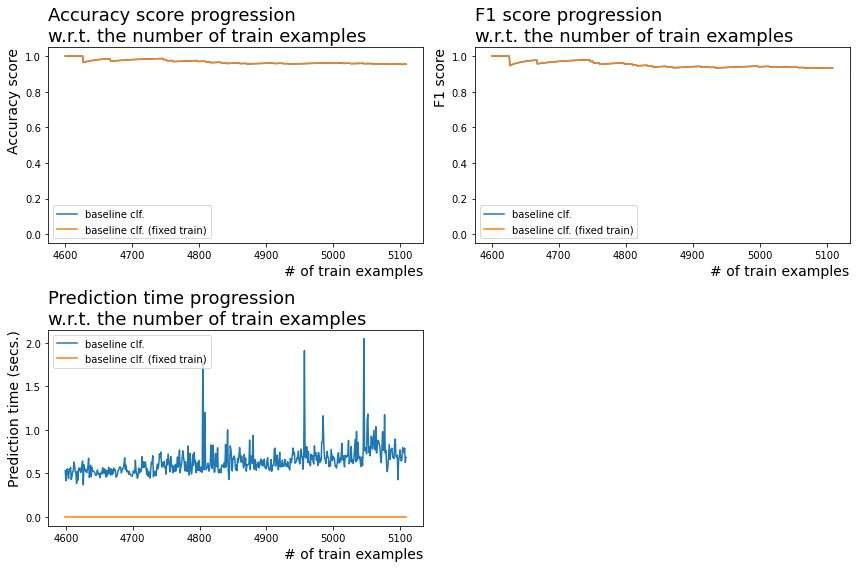

In [14]:
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = (1,1,1,1)  # Replace default "transparent" background of the figure with the "white" one


fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# First two plots are for prediction quality comparison
for ax, t in zip(axs[0],['accuracy_score', 'f1_score']):
    ax.set_ylim(0-0.05, 1+0.05)
    ax.plot(range(n_train+1, len(X)), score_vals[t], label='baseline clf.')
    ax.plot(range(n_train+1, len(X)), score_vals[t+'_fixedtrain'], label='baseline clf. (fixed train)')
    
# The third plot is for prediction speed comparison
axs[1,0].plot(range(n_train, len(X)), t_preds, label='baseline clf.')
axs[1,0].plot(range(n_train, len(X)), t_preds_fixedtrain, label='baseline clf. (fixed train)')

# Add labels and titles to the plots
for (ax, t_verb, dim) in zip(axs.flatten(), ['Accuracy score', 'F1 score','Prediction time'], ['','','(secs.)']):
    ax.set_title('\n'.join([f"{t_verb} progression", "w.r.t. the number of train examples"]), loc='left', size=18)
    ax.set_xlabel('# of train examples', loc='right', size=14)
    ax.set_ylabel(f"{t_verb} {dim}".strip(), loc='top', size=14)
    ax.legend()
    
# Drop the predefined fourth plot since we do not use it
axs[1,1].set_axis_off()    

# Some postprocessing of plots
plt.tight_layout()
plt.subplots_adjust()

plt.savefig('Classifier_comparison.png')
plt.show()